# AUDIO — Addestramento, Validazione e Salvataggio Modello

# Multimodal Stage Decoding — Notebook

Questo notebook fa parte di una pipeline in tre parti:
1. **BIO** — addestramento, validazione, salvataggio modello
2. **AUDIO** — addestramento, validazione, salvataggio modello
3. **FUSIONE tardiva (late fusion) + Viterbi** — carica i due modelli e combina le probabilità

> Assicurati che i file CSV siano presenti in `/mnt/data/`.


In [1]:

import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import joblib

plt.rcParams['figure.figsize'] = (12,6)

def select_numeric_features(df, exclude):
    return [c for c in df.columns if c not in exclude and pd.api.types.is_numeric_dtype(df[c])]

def per_participant_scale(df, feat_cols):
    out = df.copy()
    for pid, g in df.groupby('participant'):
        sc = StandardScaler()
        out.loc[g.index, feat_cols] = sc.fit_transform(g[feat_cols])
    return out

def mutual_info_topk(X, y, k=30, random_state=42):
    mi = mutual_info_classif(X, y, discrete_features=False, random_state=random_state)
    mi = np.nan_to_num(mi, nan=0.0)
    order = np.argsort(mi)[::-1]
    keep = order[:min(k, X.shape[1])]
    return keep, mi

def stage_transition_matrix(df, time_col):
    labs = df['label'].unique().tolist()
    l2i = {lab:i for i,lab in enumerate(labs)}
    n = len(labs)
    T = np.zeros((n,n), dtype=int)
    for pid, g in df.sort_values(['participant', time_col]).groupby('participant'):
        seq = g['label'].values
        for a,b in zip(seq[:-1], seq[1:]):
            T[l2i[a], l2i[b]] += 1
    T_counts = T + 1  # Laplace
    T_prob = T_counts / T_counts.sum(axis=1, keepdims=True)
    return T_prob, labs

def viterbi_decode(log_emissions, log_trans, log_start=None):
    Tlen, C = log_emissions.shape
    dp = np.full((Tlen, C), -1e18)
    ptr = np.zeros((Tlen, C), dtype=int)
    if log_start is None:
        log_start = np.zeros(C)
    dp[0] = log_start + log_emissions[0]
    for t in range(1, Tlen):
        for j in range(C):
            scores = dp[t-1] + log_trans[:, j]
            ptr[t, j] = int(np.argmax(scores))
            dp[t, j] = scores[ptr[t, j]] + log_emissions[t, j]
    path = np.zeros((Tlen,), dtype=int)
    path[-1] = int(np.argmax(dp[-1]))
    for t in range(Tlen-2, -1, -1):
        path[t] = ptr[t+1, path[t+1]]
    return path

def normalized_confusion(y_true, y_pred, class_names):
    cm = confusion_matrix(y_true, y_pred, labels=range(len(class_names)))
    cm_norm = (cm / cm.sum(axis=1, keepdims=True).clip(min=1))
    return cm, cm_norm


## Config e caricamento dati

In [2]:

AUDIO_PATH = "audioFeatures_stats.csv"
EXCLUDE = ['participant','label','label_id','abs_start_s','abs_end_s','abs_time_center','rel_time_center','rel_end_s','rel_start_s']

aud = pd.read_csv(AUDIO_PATH)
feat_cols = select_numeric_features(aud, EXCLUDE)
print("AUDIO shape:", aud.shape)
print("N feature:", len(feat_cols))
aud.head(3)


AUDIO shape: (1139, 122)
N feature: 113


,participant,mel_mean_0,mel_mean_1,mel_mean_2,mel_mean_3,mel_mean_4,mel_mean_5,mel_mean_6,mel_mean_7,mel_mean_8,...,zero_crossing_rate,rms,rel_start_s,rel_end_s,rel_time_center,abs_start_s,abs_end_s,abs_time_center,label_id,label
0,P2,-6.070770,-12.824586,-26.574017,-33.141911,-38.820103,-39.905857,-41.033279,-42.990093,-43.853500,...,0.010570,0.001449,0.0,10.0,5.0,4.0,14.0,9.0,3,pranayama
1,P2,-7.726506,-14.029783,-28.713200,-35.189045,-40.979027,-42.266251,-43.520546,-45.280216,-46.440819,...,0.009847,0.001399,10.0,20.0,15.0,14.0,24.0,19.0,3,pranayama
2,P2,-6.699770,-13.075950,-27.356506,-33.815994,-39.649498,-41.062756,-42.084602,-44.539188,-45.258831,...,0.009764,0.001357,20.0,30.0,25.0,24.0,34.0,29.0,3,pranayama


## EDA rapida

,count,percent
label,,
pranayama,336,29.50
chanting,284,24.93
meditation,283,24.85
viparita_swasa,186,16.33
breath_retention,50,4.39


label,breath_retention,chanting,meditation,pranayama,viparita_swasa
participant,,,,,
P2,7,38,28,39,22
P3,6,33,53,46,28
P4,6,55,40,52,25
P5,6,37,22,39,23
P6,9,32,35,40,25
P7,5,28,33,42,24
P8,5,38,50,50,20
P9,6,23,22,28,19


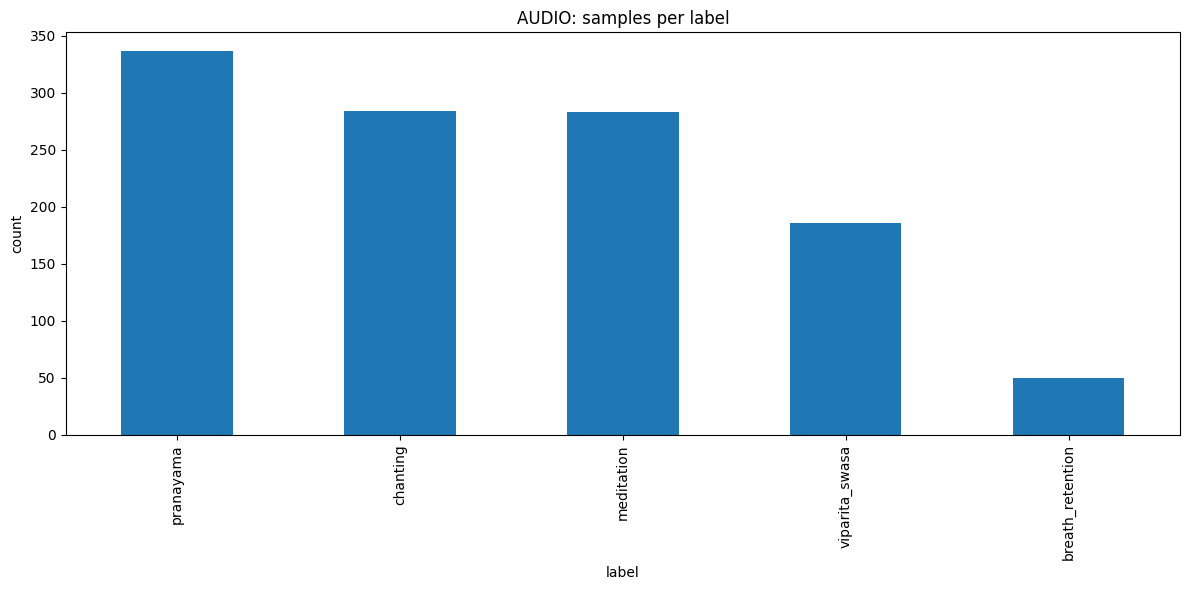

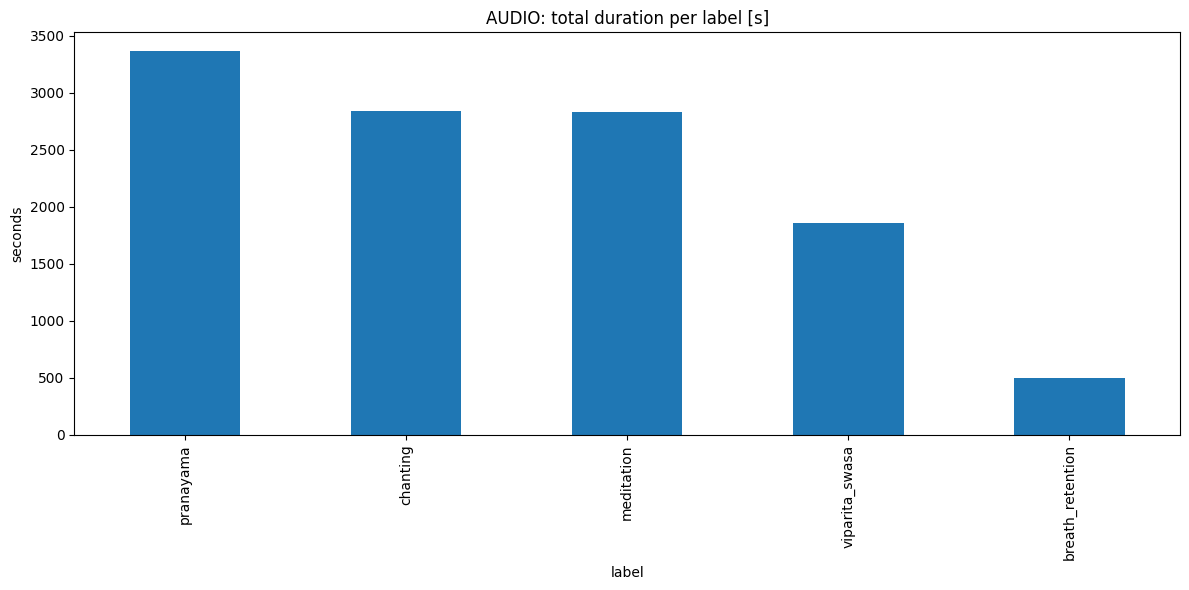

In [3]:

label_counts = aud['label'].value_counts().rename_axis("label").to_frame("count")
label_counts['percent'] = (label_counts['count']/len(aud)*100).round(2)
display(label_counts)

tab = aud.groupby(['participant','label']).size().unstack(fill_value=0)
display(tab)

plt.figure(); label_counts['count'].plot(kind='bar')
plt.title("AUDIO: samples per label"); plt.xlabel("label"); plt.ylabel("count"); plt.tight_layout(); plt.show()

if {'abs_start_s','abs_end_s'}.issubset(aud.columns):
    aud['duration'] = aud['abs_end_s'] - aud['abs_start_s']
    dur = aud.groupby('label')['duration'].sum().sort_values(ascending=False)
    plt.figure(); dur.plot(kind='bar')
    plt.title("AUDIO: total duration per label [s]"); plt.xlabel("label"); plt.ylabel("seconds"); plt.tight_layout(); plt.show()


## Normalizzazione per partecipante + MI ranking + PCA

,feature,mi
112,rms,0.419506
36,mel_std_4,0.415474
82,mfcc_std_8,0.390397
80,mfcc_std_6,0.390317
65,mfcc_mean_1,0.388164
41,mel_std_9,0.374221
37,mel_std_5,0.373784
78,mfcc_std_4,0.372463
79,mfcc_std_5,0.369827
72,mfcc_mean_8,0.361400


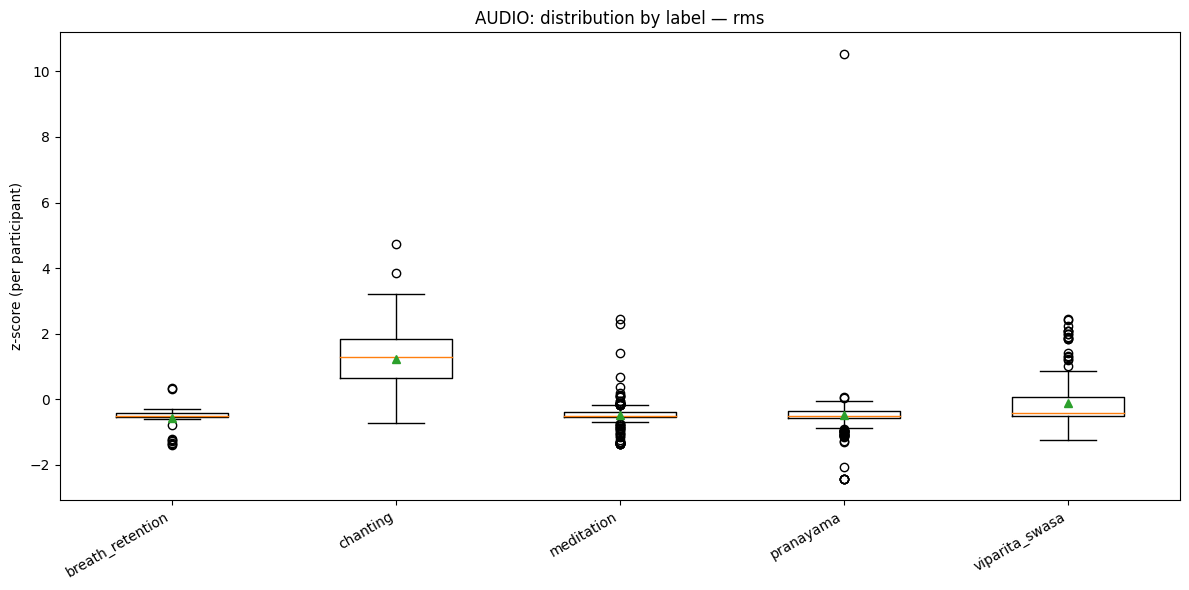

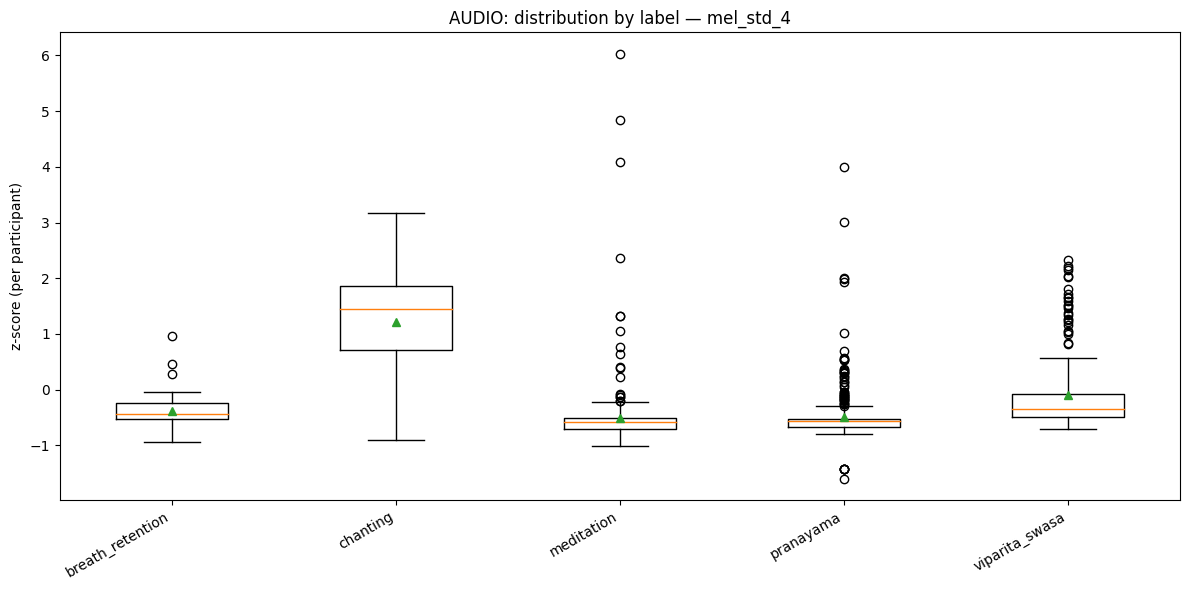

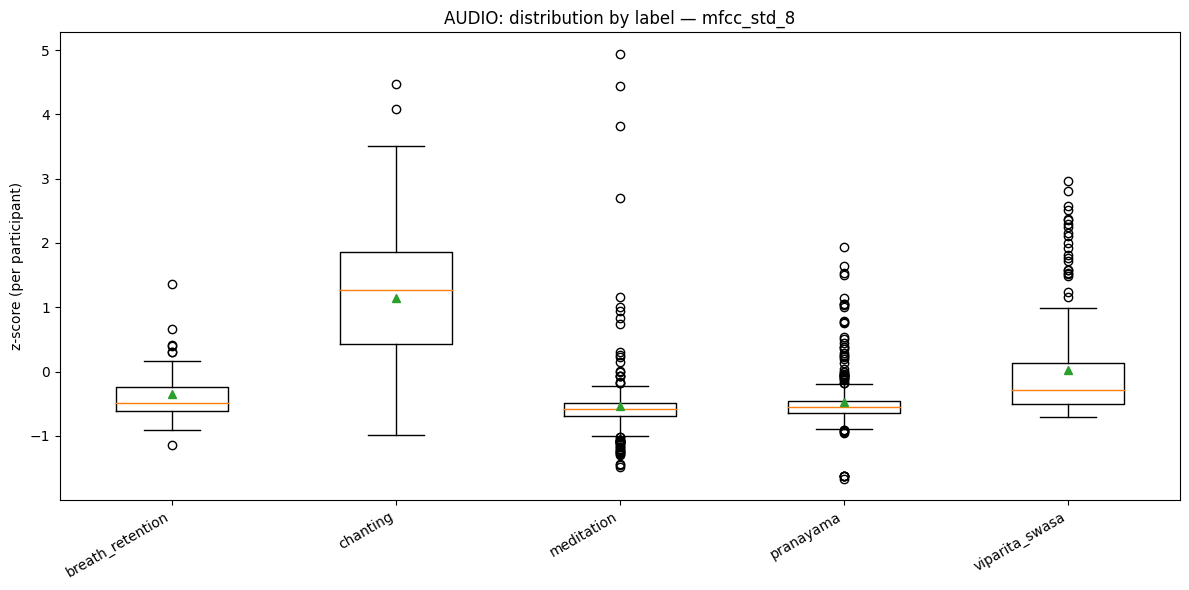

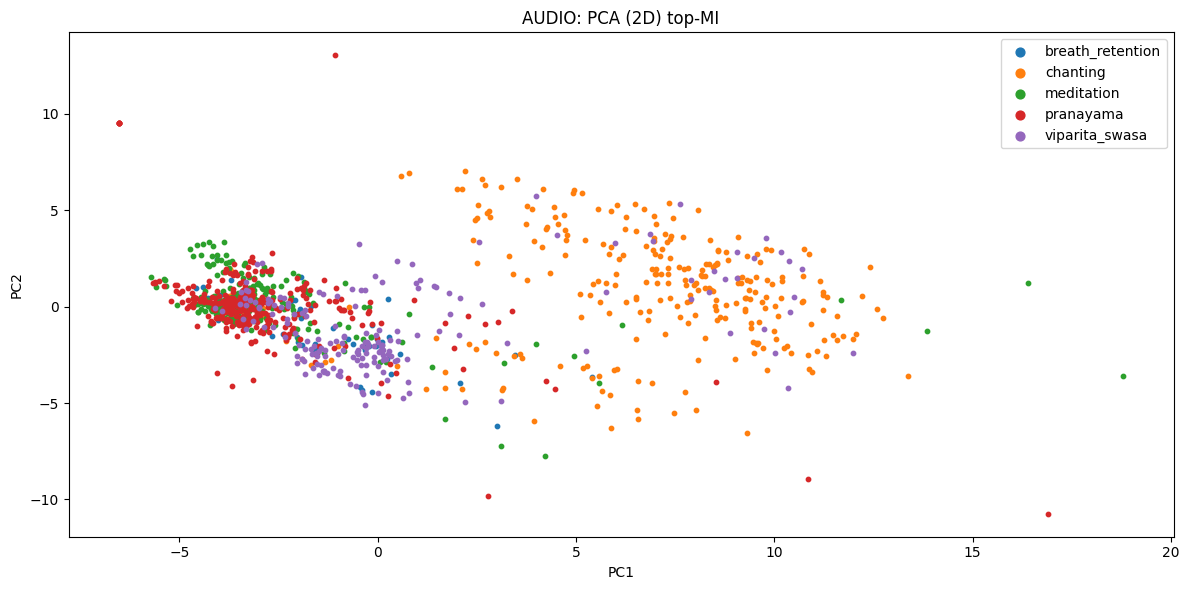

In [4]:

aud_z = per_participant_scale(aud, feat_cols)
le = LabelEncoder()
y = le.fit_transform(aud_z['label'])
classes = le.classes_.tolist()

X = aud_z[feat_cols].replace([np.inf,-np.inf], np.nan).fillna(0.0)
keep_idx, mi = mutual_info_topk(X.values, y, k=40)
mi_df = pd.DataFrame({"feature": feat_cols, "mi": mi}).sort_values("mi", ascending=False)
display(mi_df.head(30))

top3 = mi_df['feature'].head(3).tolist()
for f in top3:
    plt.figure()
    data = [aud_z.loc[aud_z['label']==lab, f].values for lab in classes]
    plt.boxplot(data, labels=classes, showmeans=True)
    plt.title(f"AUDIO: distribution by label — {f}")
    plt.xticks(rotation=30, ha='right'); plt.ylabel("z-score (per participant)"); plt.tight_layout(); plt.show()

k = min(40, len(feat_cols))
keep = mi_df.head(k)['feature'].tolist()
Z = PCA(n_components=2, random_state=42).fit_transform(X[keep])
plt.figure()
for lab in classes:
    sel = (aud_z['label']==lab).values
    plt.scatter(Z[sel,0], Z[sel,1], label=lab, s=10)
plt.title("AUDIO: PCA (2D) top-MI"); plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(markerscale=2); plt.tight_layout(); plt.show()


## Matrice di transizione & Viterbi

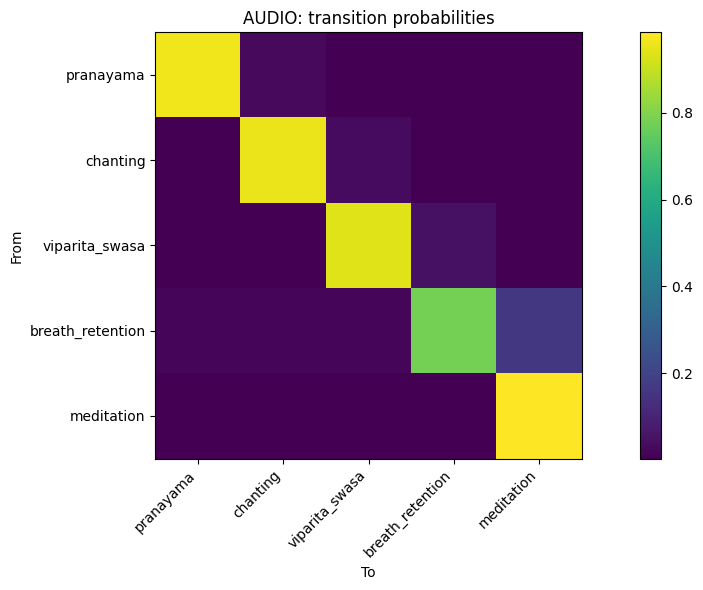

In [5]:

T_prob, labs = stage_transition_matrix(aud, 'abs_time_center')
plt.figure(); plt.imshow(T_prob, aspect='equal'); plt.title("AUDIO: transition probabilities")
plt.xlabel("To"); plt.ylabel("From")
plt.xticks(ticks=np.arange(len(labs)), labels=labs, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(labs)), labels=labs)
plt.colorbar(); plt.tight_layout(); plt.show()
logT = np.log(T_prob + 1e-9)


## Cross-validation per partecipante — RF + MI + Viterbi

AUDIO — Accuracy: 0.536 | F1-macro: 0.432


c:\Users\cecil\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\cecil\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\cecil\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

,precision,recall,f1-score,support
breath_retention,0.000,0.000,0.000,50.000
chanting,0.777,0.898,0.833,284.000
meditation,0.418,0.459,0.438,283.000
pranayama,0.425,0.443,0.434,336.000
viparita_swasa,0.510,0.409,0.454,186.000
accuracy,0.536,0.536,0.536,0.536
macro avg,0.426,0.442,0.432,1139.000
weighted avg,0.506,0.536,0.519,1139.000


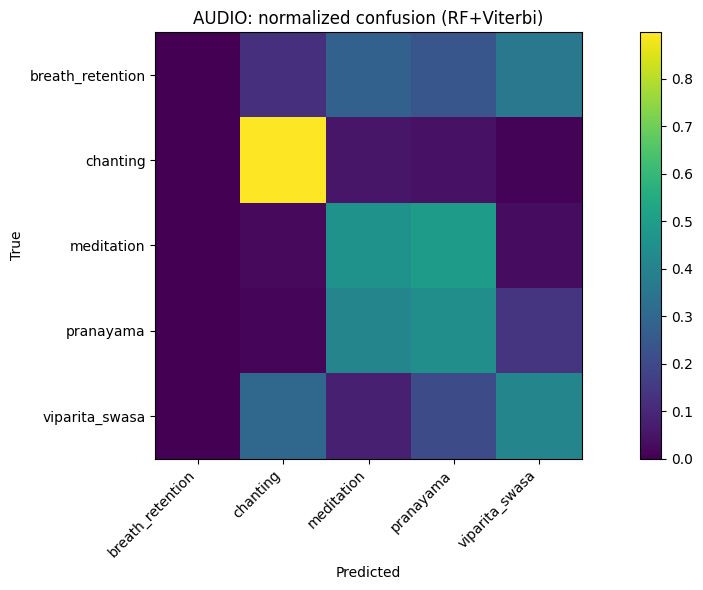

In [6]:

sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
X_all = X.values; y_all = y; groups = aud_z['participant'].values

y_true_all, y_pred_all = [], []
for fold, (tr, te) in enumerate(sgkf.split(X_all, y_all, groups=groups), start=1):
    X_tr, X_te = X_all[tr], X_all[te]; y_tr, y_te = y_all[tr], y_all[te]
    kidx, _ = mutual_info_topk(X_tr, y_tr, k=40)
    X_tr_k, X_te_k = X_tr[:, kidx], X_te[:, kidx]
    rf = RandomForestClassifier(n_estimators=500, max_depth=None, max_features='sqrt',
                                class_weight='balanced', n_jobs=-1, random_state=fold*19+5)
    rf.fit(X_tr_k, y_tr)
    prob = rf.predict_proba(X_te_k)

    te_idx = np.arange(len(te))
    df_te = aud_z.iloc[te].copy(); df_te['_idx'] = te_idx
    df_te = df_te.sort_values(['participant','abs_time_center'])
    preds = np.zeros(len(te_idx), dtype=int)
    for pid, g in df_te.groupby('participant'):
        idxs = g['_idx'].values
        log_em = np.log(prob[idxs] + 1e-9)
        path = viterbi_decode(log_em, logT)
        preds[idxs] = path
    y_true_all.append(y_te); y_pred_all.append(preds)

y_true_all = np.concatenate(y_true_all); y_pred_all = np.concatenate(y_pred_all)
print("AUDIO — Accuracy:", round(accuracy_score(y_true_all, y_pred_all),3),
      "| F1-macro:", round(f1_score(y_true_all, y_pred_all, average='macro'),3))
rep = classification_report(y_true_all, y_pred_all, target_names=classes, output_dict=True)
display(pd.DataFrame(rep).T.round(3))

cm, cmn = normalized_confusion(y_true_all, y_pred_all, classes)
plt.figure(); plt.imshow(cmn, aspect='equal'); plt.title("AUDIO: normalized confusion (RF+Viterbi)")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.xticks(ticks=np.arange(len(classes)), labels=classes, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(classes)), labels=classes)
plt.colorbar(); plt.tight_layout(); plt.show()


## LOPOCV (Leave-One-Participant-Out)

In [7]:

parts = aud['participant'].unique().tolist()
y_true_L, y_pred_L = [], []
for pid in parts:
    te_mask = (aud['participant']==pid).values
    tr_mask = ~te_mask
    train = aud.loc[tr_mask].copy()
    test  = aud.loc[te_mask].copy()

    tr_scaled = per_participant_scale(train, feat_cols)
    te_scaled = per_participant_scale(test, feat_cols)

    le2 = LabelEncoder(); y_tr = le2.fit_transform(tr_scaled['label']); y_te = np.array([list(le2.classes_).index(x) if x in list(le2.classes_) else list(le.classes_).index(x) for x in te_scaled['label']])
    X_tr = tr_scaled[feat_cols].replace([np.inf,-np.inf], np.nan).fillna(0.0).values
    X_te = te_scaled[feat_cols].replace([np.inf,-np.inf], np.nan).fillna(0.0).values

    kidx,_ = mutual_info_topk(X_tr, y_tr, k=40)
    X_tr_k, X_te_k = X_tr[:,kidx], X_te[:,kidx]

    rf = RandomForestClassifier(n_estimators=500, max_depth=None, max_features='sqrt',
                                class_weight='balanced', n_jobs=-1, random_state=123)
    rf.fit(X_tr_k, y_tr)
    prob = rf.predict_proba(X_te_k)

    df_te = te_scaled.sort_values('abs_time_center').copy()
    order_map = te_scaled.index.get_indexer(df_te.index)
    log_em = np.log(prob[order_map] + 1e-9)
    path = viterbi_decode(log_em, logT)

    y_true_L.append(np.array([classes.index(x) for x in df_te['label']]))
    y_pred_L.append(path)

y_true_L = np.concatenate(y_true_L); y_pred_L = np.concatenate(y_pred_L)
print("AUDIO LOPOCV — Accuracy:", round(accuracy_score(y_true_L, y_pred_L),3),
      "| F1-macro:", round(f1_score(y_true_L, y_pred_L, average='macro'),3))
display(pd.DataFrame(classification_report(y_true_L, y_pred_L, target_names=classes, output_dict=True)).T.round(3))


AUDIO LOPOCV — Accuracy: 0.543 | F1-macro: 0.445


c:\Users\cecil\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\cecil\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\cecil\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

,precision,recall,f1-score,support
breath_retention,0.000,0.000,0.000,50.000
chanting,0.871,0.782,0.824,284.000
meditation,0.465,0.325,0.383,283.000
pranayama,0.422,0.598,0.495,336.000
viparita_swasa,0.495,0.559,0.525,186.000
accuracy,0.543,0.543,0.543,0.543
macro avg,0.451,0.453,0.445,1139.000
weighted avg,0.538,0.543,0.532,1139.000


## Train finale e salvataggio modello AUDIO

In [10]:
RF_PARAMS = dict(
    n_estimators=500, max_depth=None, max_features='sqrt',
    class_weight='balanced', n_jobs=-1, random_state=123
)

In [12]:

aud_full = per_participant_scale(aud, feat_cols)
X_full = aud_full[feat_cols].replace([np.inf,-np.inf], np.nan).fillna(0.0).values
y_full = LabelEncoder().fit_transform(aud_full['label'].values)
keep_idx, mi = mutual_info_topk(X_full, y_full, k=40)
sel_features = [feat_cols[i] for i in keep_idx]

rf_final = RandomForestClassifier(**RF_PARAMS)
rf_final.fit(X_full[:, keep_idx], y_full)

model = {
    "rf": rf_final,
    "selected_features": sel_features,
    "classes": classes,
    "exclude_cols": EXCLUDE,
    "scaler": "StandardScaler_per_participant",
    "transition_matrix": stage_transition_matrix(aud, 'abs_time_center')[0],
    "rf_params": RF_PARAMS
}
model["feature_selection"] = {
    "method": "mutual_info_classif",
    "k": len(sel_features),
    "random_state": 42,
    "scope": "final_full_dataset",
    "scaling": "per_participant"  # metti "none" se decidi di non scalarlo
}
model_dir = Path("./models")
model_dir.mkdir(parents=True, exist_ok=True)

# salva il modello
joblib.dump(model, model_dir / "audio_rf_model.joblib")
print("Salvato:", model_dir / "audio_rf_model.joblib")



Salvato: models\audio_rf_model.joblib
